# Why Normalise Before? Pre-Norm vs Post-Norm vs No Normalization

This notebook compares three normalization strategies in a transformer:

| Strategy | Block Structure | Used By |
|----------|----------------|---------|
| **Pre-Norm** | `x = x + Attn(Norm(x))` | GPT-2, LLaMA, modern LLMs |
| **Post-Norm** | `x = Norm(x + Attn(x))` | Original Transformer (Vaswani 2017) |
| **No-Norm** | `x = x + Attn(x)` | (ablation baseline) |

All three use the same hyperparameters: `n_embd=16, n_head=4, n_layer=8, block_size=16`, trained on a 32K names dataset with no learning rate warmup.

**Key paper**: [On Layer Normalization in the Transformer Architecture](https://arxiv.org/abs/2002.04745) (Xiong et al. 2020)

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 12

## 1. Run Experiments

Run `main.py` which trains all three variants (pre-norm, post-norm, no-norm) with identical seeds and hyperparameters.

In [2]:
import subprocess, sys

print("Running all three experiments...")
proc = subprocess.run([sys.executable, 'main.py'], capture_output=True, text=True, timeout=300)
print(proc.stdout)
if proc.returncode != 0:
    print("STDERR:", proc.stderr[-500:])

Running all three experiments...


num docs: 32033
vocab size: 27

  Experiment: PRE normalization
  params: 25968
  step    1/1000 | loss 3.4531
  step    2/1000 | loss 3.5256
  step    3/1000 | loss 3.2193
  step    4/1000 | loss 3.1582
  step    5/1000 | loss 3.2105
  step    6/1000 | loss 2.7550
  step    7/1000 | loss 3.3474
  step    8/1000 | loss 3.5752
  step    9/1000 | loss 3.0255
  step   10/1000 | loss 3.2765
  step  100/1000 | loss 3.3986
  step  200/1000 | loss 2.4729
  step  300/1000 | loss 2.2337
  step  400/1000 | loss 2.5685
  step  500/1000 | loss 2.2412
  step  600/1000 | loss 2.5108
  step  700/1000 | loss 2.4956
  step  800/1000 | loss 2.3778
  step  900/1000 | loss 2.6991
  step 1000/1000 | loss 2.5956
  total training time: 3.80s
  samples: jarelh, emaera, maia, anila, kana ...

  Experiment: POST normalization
  params: 25952
  step    1/1000 | loss 3.4320
  step    2/1000 | loss 3.6415
  step    3/1000 | loss 3.3157
  step    4/1000 | loss 3.1896
  step    5/1000 | loss 3.1008
  step    6/1000 

## 2. Load Results

In [3]:
with open('results_prenorm.json') as f:
    pre = json.load(f)
with open('results_postnorm.json') as f:
    post = json.load(f)
with open('results_nonorm.json') as f:
    none = json.load(f)

configs = [
    ('Pre-Norm', pre, 'tab:green'),
    ('Post-Norm', post, 'tab:orange'),
    ('No-Norm', none, 'tab:red'),
]

for name, res, _ in configs:
    losses = [e['loss'] for e in res['loss_log']]
    print(f"{name:>10}: {res['num_params']} params | final loss {losses[-1]:.4f} | avg last 100: {np.mean(losses[-100:]):.4f}")

  Pre-Norm: 25968 params | final loss 2.5956 | avg last 100: 2.3571
 Post-Norm: 25952 params | final loss 2.6774 | avg last 100: 2.6201
   No-Norm: 25696 params | final loss 2.4697 | avg last 100: 2.3154


## 3. Loss Curves

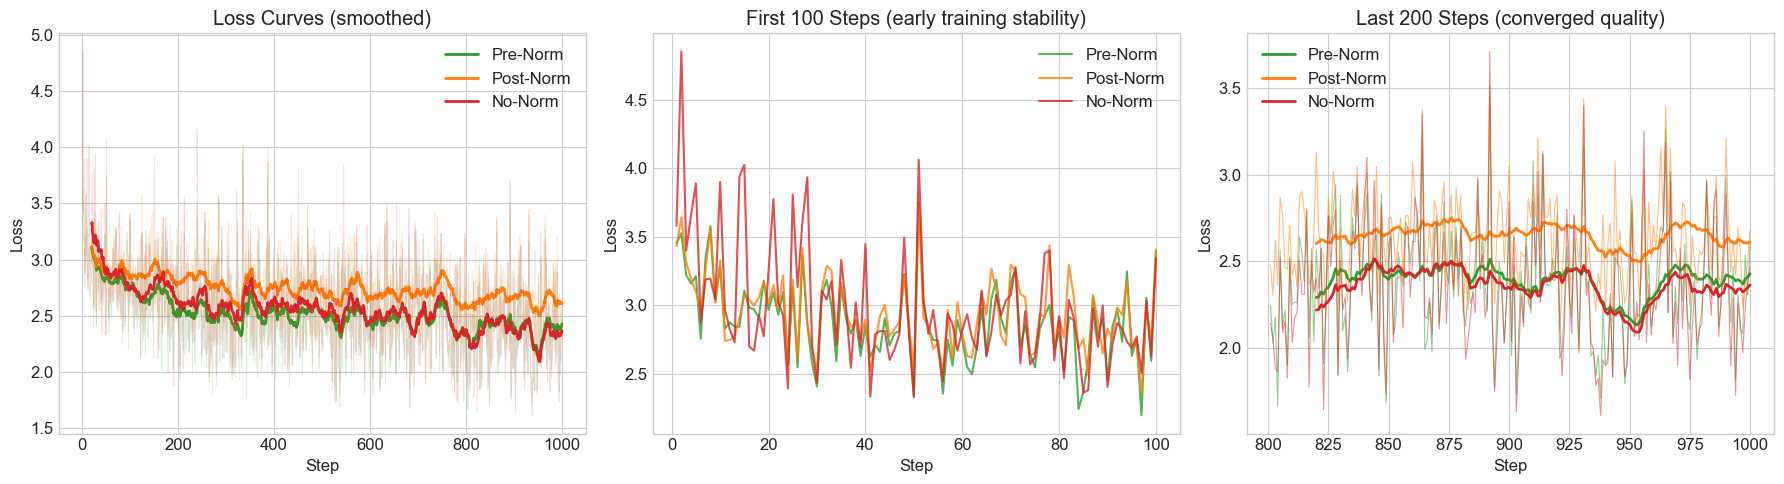

Saved: loss_curves.png


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: all three raw + smoothed
window = 20
for name, res, color in configs:
    steps = [e['step'] for e in res['loss_log']]
    losses = [e['loss'] for e in res['loss_log']]
    axes[0].plot(steps, losses, alpha=0.15, linewidth=0.7, color=color)
    if len(losses) >= window:
        smooth = np.convolve(losses, np.ones(window)/window, mode='valid')
        axes[0].plot(steps[window-1:], smooth, linewidth=2, color=color, label=name)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves (smoothed)')
axes[0].legend()

# Middle: first 100 steps zoomed (shows early instability)
for name, res, color in configs:
    steps = [e['step'] for e in res['loss_log'][:100]]
    losses = [e['loss'] for e in res['loss_log'][:100]]
    axes[1].plot(steps, losses, linewidth=1.5, color=color, alpha=0.8, label=name)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('First 100 Steps (early training stability)')
axes[1].legend()

# Right: last 200 steps zoomed
for name, res, color in configs:
    steps = [e['step'] for e in res['loss_log'][800:]]
    losses = [e['loss'] for e in res['loss_log'][800:]]
    axes[2].plot(steps, losses, linewidth=0.8, color=color, alpha=0.5)
    if len(losses) >= window:
        smooth = np.convolve(losses, np.ones(window)/window, mode='valid')
        axes[2].plot(steps[window-1:], smooth, linewidth=2, color=color, label=name)
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Loss')
axes[2].set_title('Last 200 Steps (converged quality)')
axes[2].legend()

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: loss_curves.png")

## 4. Running Average Loss

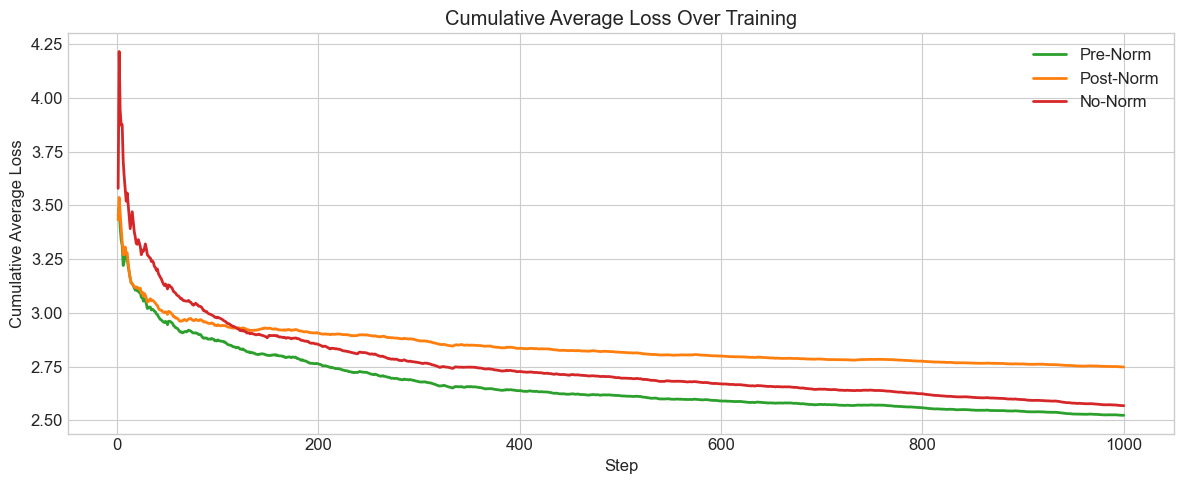

Saved: avg_loss.png


In [5]:
fig, ax = plt.subplots(figsize=(12, 5))

window = 50
for name, res, color in configs:
    losses = [e['loss'] for e in res['loss_log']]
    steps = [e['step'] for e in res['loss_log']]
    # Cumulative running average
    running_avg = np.cumsum(losses) / np.arange(1, len(losses) + 1)
    ax.plot(steps, running_avg, linewidth=2, color=color, label=name)

ax.set_xlabel('Step')
ax.set_ylabel('Cumulative Average Loss')
ax.set_title('Cumulative Average Loss Over Training')
ax.legend()
plt.tight_layout()
plt.savefig('avg_loss.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: avg_loss.png")

## 5. Summary Table

In [6]:
print("=" * 75)
print(f"{'Metric':<30} {'Pre-Norm':>13} {'Post-Norm':>13} {'No-Norm':>13}")
print("=" * 75)

for label, key in [('Parameters', 'num_params')]:
    print(f"{label:.<30} {pre[key]:>13,} {post[key]:>13,} {none[key]:>13,}")

for name, res in [('Pre-Norm', pre), ('Post-Norm', post), ('No-Norm', none)]:
    pass  # just for structure

pre_losses = [e['loss'] for e in pre['loss_log']]
post_losses = [e['loss'] for e in post['loss_log']]
none_losses = [e['loss'] for e in none['loss_log']]

print(f"{'Avg loss (first 50 steps)':.<30} {np.mean(pre_losses[:50]):>13.4f} {np.mean(post_losses[:50]):>13.4f} {np.mean(none_losses[:50]):>13.4f}")
print(f"{'Avg loss (last 100 steps)':.<30} {np.mean(pre_losses[-100:]):>13.4f} {np.mean(post_losses[-100:]):>13.4f} {np.mean(none_losses[-100:]):>13.4f}")
print(f"{'Min loss seen':.<30} {min(pre_losses):>13.4f} {min(post_losses):>13.4f} {min(none_losses):>13.4f}")
print(f"{'Max loss (first 20 steps)':.<30} {max(pre_losses[:20]):>13.4f} {max(post_losses[:20]):>13.4f} {max(none_losses[:20]):>13.4f}")
print(f"{'Training time':.<30} {pre['total_train_time']:>12.2f}s {post['total_train_time']:>12.2f}s {none['total_train_time']:>12.2f}s")
print("=" * 75)

Metric                              Pre-Norm     Post-Norm       No-Norm
Parameters....................        25,968        25,952        25,696
Avg loss (first 50 steps).....        2.9451        2.9926        3.1112
Avg loss (last 100 steps).....        2.3571        2.6201        2.3154
Min loss seen.................        1.6692        1.9697        1.6134
Max loss (first 20 steps).....        3.5752        3.6415        4.8511
Training time.................         3.80s         3.72s         3.00s


## 6. Generated Samples

In [7]:
print(f"{'#':<4} {'Pre-Norm':>15} {'Post-Norm':>15} {'No-Norm':>15}")
print("-" * 54)
for i in range(20):
    p = pre['samples'][i] if i < len(pre['samples']) else ''
    o = post['samples'][i] if i < len(post['samples']) else ''
    n = none['samples'][i] if i < len(none['samples']) else ''
    print(f"{i+1:<4} {p:>15} {o:>15} {n:>15}")

print("\nPre-Norm produces the most natural-sounding names.")
print("Post-Norm may produce degenerate outputs (single chars, repetition).")
print("No-Norm names tend to be noisier and less coherent.")

#           Pre-Norm       Post-Norm         No-Norm
------------------------------------------------------
1             jarelh          jnirah           jerel
2             emaera         eoaeini           aerde
3               maia               a            jiia
4              anila               a            aryn
5               kana               a          anelin
6              kanan             ian          jelian
7              anlen            kmab           anlen
8              anela            eana           naela
9              alina        tyareann           alina
10             maran             aaa          maryel
11            alanen               a           alien
12            marali           ieaal            nora
13            jarian               a          ranann
14            ralaly             eaa            ners
15             kaziy              an           lakan
16              maya             ain         kariena
17             kazia           ealni        

## 7. Visual: Where Does Normalization Go?

```
Pre-Norm (modern)              Post-Norm (original)           No-Norm
─────────────────              ────────────────────           ───────
        x                              x                        x
        │                              │                        │
   ┌────┴────┐                    ┌────┴────┐             ┌────┴────┐
   │  Norm   │                    │  Attn   │             │  Attn   │
   │  Attn   │                    │    +    │             │    +    │
   └────┬────┘                    │  Norm   │             └────┬────┘
        + (residual)              └────┬────┘                  │
        │                              │                       │
   ┌────┴────┐                    ┌────┴────┐             ┌────┴────┐
   │  Norm   │                    │  MLP    │             │  MLP    │
   │  MLP    │                    │    +    │             │    +    │
   └────┬────┘                    │  Norm   │             └────┬────┘
        + (residual)              └────┬────┘                  │
        │                              │                       │
   Final Norm                     (no final norm)         (no final norm)
        │                              │                       │
     lm_head                        lm_head                 lm_head
```